# Data Wrangling process for creating the dataset
**Note**: This notebook is mainly to serve as an explanation for the data collection and pre-processing stages. If you'd like to create the dataset for yourself, I'd recommend `... .py` which does so more efficiently.


This notebook contains the complete and chronological process of creating the training dataset for the CNN Speaker Counter. It's sectioned as following:

- **Pre-Processing of LibriCSS**: The initial extraction from libricss. This involved turning the raw .wav files into 1 second mono clips, creating a spectrogram of each clip, and fetching the number of speakers for each clip from the libricss metadata. This provided a supervised dataset for modelling 0-2 speakers.
- **Generating overlayed clips from LibriCSS clips**: As the goal of the model was to predict more than 2 speakers at once, data augmentation was required. By overlaying existing clips and summing their speaker counts, new synthetic data was created. Quality was not affected as the input and output of the overlaying was mono.
- **Adding further data: "RIRs & Noise" and more**: A larger and more diverse dataset resulted from adding synthetic data. But there was still a class imbalance, specifically in class `0`, or 'no speakers'. Adding data from a noise dataset was considered; the author even recorded their own noise `...`

In [1]:
import os
from pathlib import Path
import librosa
import re
from time import time
import ast
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import Audio, display
import soundfile as sf
from scipy.io import wavfile

from src.utils.SpectrogramExtractor import SpectrogramExtractor         # Custom class to create a spectrogram from a .wav

## Pre-Processing of LibriCSS
LibriCSS contains raw recordings of multi-channel audio. Each recording has a given level of overlap, ranging from 0 to 40%. These recordings are divided up into small learnable clips, so that each clip may contain no speakers, a single speaker or two overlapping speakers. 

Next, meeting information metadata gives the start and end times of each 'utterance' - a phrase said by a single speaker.

By cross-referencing the meeting information files to the audio clips, a label is created showing how many speakers are active in each clip. This gives a supervised data set that can be used in ML processes.

### Converting LibriCSS to spectrograms with labelled speaker counts

1. Collect paths for recordings and metadata
2. Transform raw_recordings into 1 second mono clips.
3. Create a spectrogram of each clip. 
4. Use metadata to extract the labels for each clip - how many speakers there are.

#### Step 1 - Collect libricss paths

In [3]:
# Collect list of paths in libricss dataset. Returns the raw recording wav paths & the meeting_info txt paths (in pairs).
# So for each session there is (raw_recording.wav, meeting_info.txt)
def collect_paths(root_dir):
    pairs = []

    for overlap_dir in Path(root_dir).iterdir():
        if not overlap_dir.is_dir():
            continue

        for session_dir in overlap_dir.iterdir():
            raw_path = session_dir / "record" / "raw_recording.wav"
            info_path = session_dir / "transcription" / "meeting_info.txt"
            if raw_path.exists() and info_path.exists():
                pairs.append((raw_path, info_path))

    return pairs

#### Step 2 - Split recordings into 1s mono clips

In [4]:
# Extracts clips of length clip_dur from a .wav
def split_wav_into_clips(wav_path, clip_dur=1.0, sr=16000):
    wav, _ = librosa.load(wav_path, sr=sr, mono=True) # librosa handles mono conversion for us
    clip_len = int(clip_dur * sr)
    num_clips = len(wav) // clip_len

    clips = [
        wav[i * clip_len : (i + 1) * clip_len]
        for i in range(num_clips)
    ]
    return clips


# Iterate over libricss paths with collect_paths() (step 1) and for each .wav file execute split_wav_into_clips() (above)
def wavs_to_clips(in_dir = "data/libricss", out_dir = "data/clips_libricss"):
    
    #str to Path
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    for raw_path, _ in collect_paths(in_dir):

        # Formatting for file names
        speaker = raw_path.parents[2].name
        session_folder = raw_path.parents[1].name
        m = re.search(r"(session\d+)", session_folder)
        session = m.group(1) if m else session_folder

        # Split raw_path into 1s clips
        clips = split_wav_into_clips(raw_path, clip_dur=1.0, sr=16000)

        # Save clips (except the first and last clip as they are 'beeps' to signify the start/end of recordings)
        for idx, clip in enumerate(clips[1:-1], start=1):
            fname = f"{speaker}_{session}_clip{idx}.wav"
            sf.write(out_dir / fname, clip, 16000)

#### Step 3 - turn each clip into spectrogram

In [5]:
# Iterate through clips_dir and convert each to a spectrogram. Deposit them to specs_dir as .pt files (best for training with torch)
def clips_to_specs(clips_dir, specs_dir):
    extractor = SpectrogramExtractor()          # See 'src\utils\SpectrogramExtractor.py'

    clips_dir = Path(clips_dir)
    specs_dir = Path(specs_dir)
    specs_dir.mkdir(parents=True, exist_ok=True)

    # Convert all clips to spectrograms
    for wav_path in clips_dir.glob("*.wav"):

        spec = extractor(str(wav_path))         # Returns a tensor shape: [1, n_mels, time_frames]
        spec = spec.squeeze(0)                  # Remove the leading channel dim. Now [n_mels, time_frames]
        

        out_path = specs_dir / wav_path.with_suffix(".pt").name
        torch.save(spec, out_path) # save as a PyTorch tensor

#### Executing Steps 1-3
(uncomment to run. The folders `data/clips_libricss` and `data/specs_libricss` must exist and be empty.)

In [6]:
#wavs_to_clips()
#clips_to_specs(clips_dir = r'data/clips_libricss', specs_dir= r'data/specs_libricss')

#### Step 4 - Labels for each spectrogram

In [6]:
# Count the active speakers in a clip using libricss metadata. Uses a 'minimum overlap' of 0.2s. e.g. if a speech window is 1.9-4.1, the result will be [2,3], NOT [1,2,3,4]. Trailing speech is bad for learning. 
def count_speakers_per_window(meeting_file, time_window=1.0, min_overlap=0.2):
    intervals = []
    with open(meeting_file, "r") as f:
        next(f) # Skip header
        for line in f:
            parts = line.strip().split()    # This part manually pulls data from meeting_file, line by line
            start_time = float(parts[0])
            end_time = float(parts[1])
            speaker_id = parts[2]
            intervals.append((start_time, end_time, speaker_id))

    if not intervals:   # Early exit for empty files
        return []

    max_time = max(end for _, end, _ in intervals)
    num_windows = math.ceil(max_time / time_window)
    
    results = [{"speaker_count": 0, "speakers": []} for _ in range(num_windows)]    # init the results list

    for i in range(num_windows):    # for each window in the clip, find it's start and end
        window_start = i * time_window
        window_end = window_start + time_window
        active_speakers = set()

        for seg_start, seg_end, speaker_id in intervals:        # Compare the start and end of each utterance with the start and end of the current window;
            overlap_start = max(seg_start, window_start)
            overlap_end = min(seg_end, window_end)
            if (overlap_end - overlap_start) >= min_overlap:    # if there is a hit, add to the set of active speakers for that window;
                active_speakers.add(speaker_id)

        results[i]["speaker_count"] = len(active_speakers)      # add to results list.
        results[i]["speakers"] = list(active_speakers)

    return results



# Final step: build a dict {spectrogram path -> its label, from 1)}

# Collect Key paths
specs_dir = Path("data/specs_libricss")                       
spec_to_label = {}


# Collect value paths
counts_map = {}
for _, info_path in collect_paths("data/libricss"):
    speaker = info_path.parents[2].name 
    session_folder = info_path.parents[1].name
    

    m = re.search(r"(session\d+)", session_folder)          # Search for the meeting_info.txt file
    session = m.group(1) if m else session_folder
    
    key = f"{speaker}_{session}"              
    counts_map[key] = count_speakers_per_window(info_path)  # Run the wrapper defined above



# Create key/value pair from paths
for spec_path in specs_dir.glob("*.pt"):

    stem = spec_path.stem               # extracts the filename without the extension
    parts = stem.rsplit("_clip", 1)     # Seperates the session key and clip index (specific to libricss naming convention)

    if len(parts) != 2:                 # skips files that dont match the expected pattern
        continue  
    
    key, idx_str = parts                # assigns the session key and clip index
    idx = int(idx_str)
    
    if key not in counts_map:           # sanity check
        raise KeyError(f"No counts for session key '{key}'")
    

    counts = counts_map[key]            # gets the list of speaker count results for the session

    if idx < 0 or idx >= len(counts):   # another sanity check
        raise IndexError(f"Clip index {idx} out of range for '{key}'")
    
    # result
    spec_to_label[spec_path] = counts[idx] 



# Result as df
records = [
    {
        "spec_dir": str(spec_path),  # full path to .pt
        "clip_dir": str(Path("data/clips_libricss") / (spec_path.stem + ".wav")),  # relative clip path
        "speaker_count": label["speaker_count"],
        "speakers": label["speakers"]
    }
    for spec_path, label in spec_to_label.items()
]
df = pd.DataFrame(records)

# Get rid of noisy/nonsense results (there are only 0,1,2 speaker counts in the dataset. Some show higher, due to bad rounding)
df = df[df['speaker_count'] < 3]


# Save labels to csv and show
df.to_csv("data/labels/libricss.csv", index=False); df.tail(10)

,spec_dir,clip_dir,speaker_count,speakers
36189,data\specs_libricss\OV40_session9_clip90.pt,data\clips_libricss\OV40_session9_clip90.wav,2,"[1995, 2961]"
36190,data\specs_libricss\OV40_session9_clip91.pt,data\clips_libricss\OV40_session9_clip91.wav,1,[2961]
36191,data\specs_libricss\OV40_session9_clip92.pt,data\clips_libricss\OV40_session9_clip92.wav,1,[2961]
36192,data\specs_libricss\OV40_session9_clip93.pt,data\clips_libricss\OV40_session9_clip93.wav,1,[2961]
36193,data\specs_libricss\OV40_session9_clip94.pt,data\clips_libricss\OV40_session9_clip94.wav,1,[2961]
36194,data\specs_libricss\OV40_session9_clip95.pt,data\clips_libricss\OV40_session9_clip95.wav,1,[2961]
36195,data\specs_libricss\OV40_session9_clip96.pt,data\clips_libricss\OV40_session9_clip96.wav,1,[2961]
36196,data\specs_libricss\OV40_session9_clip97.pt,data\clips_libricss\OV40_session9_clip97.wav,2,"[7176, 2961]"
36197,data\specs_libricss\OV40_session9_clip98.pt,data\clips_libricss\OV40_session9_clip98.wav,2,"[7176, 2961]"
36198,data\specs_libricss\OV40_session9_clip99.pt,data\clips_libricss\OV40_session9_clip99.wav,2,"[7176, 2961]"


### Results of converting libricss into labelled 1s clips

In [2]:
def plot_spectrogram_with_audio(audio_dir, spec_dir, clip, df, hop_ms=10):

    """
    Args:
        audio_dir: The folder name of the audio file(s). e.g. data/audio --> audio_path = 'audio'
        spec_dir: The folder name of the spectrogram file(s).
        clip: The specific clip being shown
        df: The relevant dataframe (for the title)
        hop_ms: The x-axis spacing. Leave as-is.
    """

    audio_path = f'data\{audio_dir}\{clip}.wav'
    spec_path = f'data\{spec_dir}\{clip}.pt'

    rate, waveform = wavfile.read(audio_path)       # Load and play audio
    display(Audio(waveform, rate=rate))

    spectrogram = torch.load(spec_path).squeeze()   # Load spectrogram

    # Lookup speaker count for title
    row = df.loc[df['spec_dir'] == f'data\{spec_dir}\{clip}.pt', 'speaker_count']
    speaker_count = row.values[0] if not row.empty else 'Unknown'

    # Calculate time axis
    n_frames = spectrogram.shape[1]
    duration_sec = (n_frames * hop_ms) / 1000

    # Plot
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram.numpy(), aspect='auto', origin='lower',
               extent=[0, duration_sec, 0, spectrogram.shape[0]],
               cmap='magma')
    plt.title(f'Speaker Count: {speaker_count}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency bins')
    plt.colorbar(label='Amplitude')
    plt.tight_layout()
    plt.show()

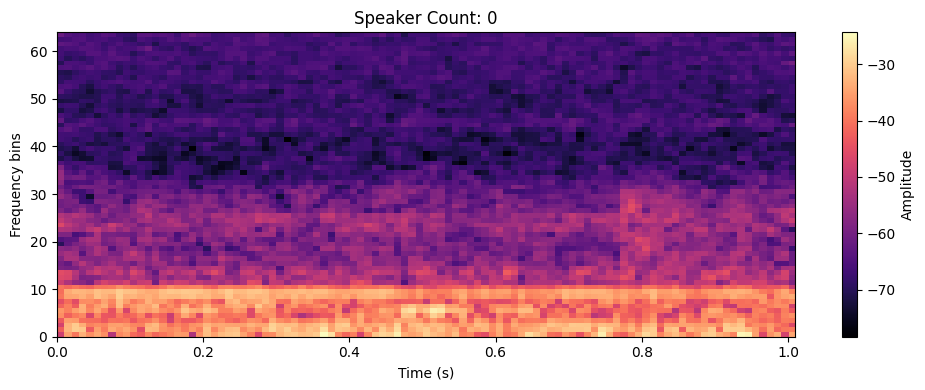

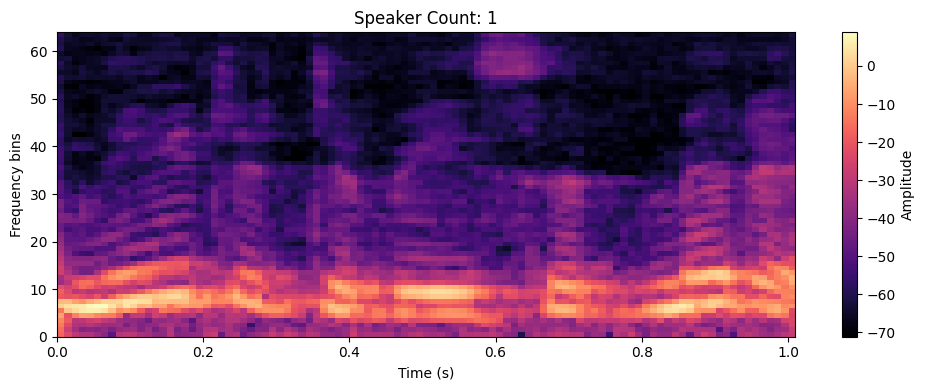

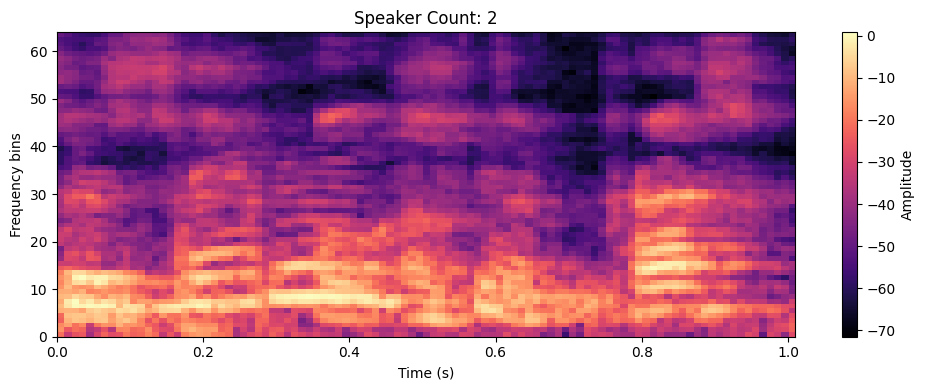

In [7]:
plot_spectrogram_with_audio(audio_dir=r'clips_libricss', spec_dir=r'specs_libricss', clip = r'0L_session1_clip2', df = df)     # 0 speaker example
plot_spectrogram_with_audio(audio_dir=r'clips_libricss', spec_dir=r'specs_libricss', clip = r'OV40_session9_clip150', df = df)     # 1 speaker example
plot_spectrogram_with_audio(audio_dir=r'clips_libricss', spec_dir=r'specs_libricss', clip = r'OV40_session9_clip154', df = df)     # 2 speaker example

### Scrutinising the resulting data

In [10]:
_df = pd.read_csv(r'data\spectrogram_labels.csv')
_class_counts = [len(_df[_df['speaker_count'] == i]) for i in range(3)]
for i in range(len(_class_counts)):
    print(f"Clips with {i} speakers: {_class_counts[i]}")

Clips with 0 speakers: 1527
Clips with 1 speakers: 29309
Clips with 2 speakers: 5251


... it's clear there is a class imbalance. Additionally, this only covers 0-2 speakers. To improve the dataset we should:

- Fix the class imbalance
- Add data with more speakers at once

## Balancing the 0 speaker class
To be learnable, many more than 1527 samples is needed. The model should have a strong idea of what no speakers sounds like, otherwise it might assume that static or noise is a speaker. We have two sources for 'noise' data:

- The **RIR & Noise** dataset (https://www.openslr.org/28)
- The authors own recordings

By labelling a variety of noise as 'no speakers', the model will implicitly also be a voice activity detection (VAD) model.

In [11]:
metadata = Path('data/rirs_noises/real_rirs_isotropic_noises/noise_list')

# Extract paths from metadata file
wav_pattern = re.compile(r'(RIRS_NOISES/[\w/]+\.wav)')

# Load and parse as text
with open(metadata, 'r') as f: content = f.read()

# pull .wavs 
wav_files = [f"data/{match}" for match in wav_pattern.findall(content)]; print(wav_files)

['data/RIRS_NOISES/real_rirs_isotropic_noises/RVB2014_type1_noise_largeroom1_1.wav', 'data/RIRS_NOISES/real_rirs_isotropic_noises/RVB2014_type1_noise_largeroom1_10.wav', 'data/RIRS_NOISES/real_rirs_isotropic_noises/RVB2014_type1_noise_largeroom1_2.wav', 'data/RIRS_NOISES/real_rirs_isotropic_noises/RVB2014_type1_noise_largeroom1_3.wav', 'data/RIRS_NOISES/real_rirs_isotropic_noises/RVB2014_type1_noise_largeroom1_4.wav', 'data/RIRS_NOISES/real_rirs_isotropic_noises/RVB2014_type1_noise_largeroom1_5.wav', 'data/RIRS_NOISES/real_rirs_isotropic_noises/RVB2014_type1_noise_largeroom1_6.wav', 'data/RIRS_NOISES/real_rirs_isotropic_noises/RVB2014_type1_noise_largeroom1_7.wav', 'data/RIRS_NOISES/real_rirs_isotropic_noises/RVB2014_type1_noise_largeroom1_8.wav', 'data/RIRS_NOISES/real_rirs_isotropic_noises/RVB2014_type1_noise_largeroom1_9.wav', 'data/RIRS_NOISES/real_rirs_isotropic_noises/RVB2014_type1_noise_largeroom2_1.wav', 'data/RIRS_NOISES/real_rirs_isotropic_noises/RVB2014_type1_noise_largeroom

In [8]:
# Convert a list [] of wav files into clips, one by one. Uses `split_wav_into_clips()`, a helper from part 1.
def wavs_to_clips_from_list(wav_list, out_dir):

    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)


    for raw_path in wav_list:
        raw_path = Path(raw_path)

        # Formatting for file names
        speaker = raw_path.parents[2].name
        session_folder = raw_path.parents[1].name
        m = re.search(r"(session\d+)", session_folder)
        session = m.group(1) if m else session_folder


        # Split raw_path into 1s clips
        clips = split_wav_into_clips(raw_path, clip_dur=1.0, sr=16000)


        # Parse good files only
        base = raw_path.stem
        m = re.match(r"RVB2014_type\d+_noise_(\w+)_(\d+)", base)
        if not m:
            print(f"Skipping unexpected filename: {base}")      # skip bad files (broken or not good for training)
            continue
        room, sample_num = m.groups()


        for idx, clip in enumerate(clips, start=1):
            fname = f"{room}_{sample_num}_clip{idx}.wav"
            sf.write(out_dir / fname, clip, 16000)


# Run
#wavs_to_clips_from_list(wav_files, out_dir="data/clips_rir")


# Convert new clips to specs
specs_dir = "data/specs_rir"
#clips_to_specs(clips_dir="data/clips_rir", specs_dir=specs_dir)


# List all spectrogram files
specs_dir = Path(specs_dir)
spec_files = sorted(specs_dir.glob("*.pt"))


records = [
    {
        "spec_dir": str(spec_path),
        "clip_dir": str(Path("data/clips_rir") / (spec_path.stem + ".wav")),
        "speaker_count": 0,
        "speakers": []
    }
    for spec_path in spec_files
]
df_noise = pd.DataFrame(records)


# Save to CSV
df_noise.to_csv("data/labels/noise.csv", index=False)
df_noise

,spec_dir,clip_dir,speaker_count,speakers
0,data\specs_rir\largeroom1_10_clip1.pt,data\clips_rir\largeroom1_10_clip1.wav,0,[]
1,data\specs_rir\largeroom1_10_clip10.pt,data\clips_rir\largeroom1_10_clip10.wav,0,[]
2,data\specs_rir\largeroom1_10_clip11.pt,data\clips_rir\largeroom1_10_clip11.wav,0,[]
3,data\specs_rir\largeroom1_10_clip12.pt,data\clips_rir\largeroom1_10_clip12.wav,0,[]
4,data\specs_rir\largeroom1_10_clip13.pt,data\clips_rir\largeroom1_10_clip13.wav,0,[]
...,...,...,...,...
2695,data\specs_rir\smallroom2_9_clip5.pt,data\clips_rir\smallroom2_9_clip5.wav,0,[]
2696,data\specs_rir\smallroom2_9_clip6.pt,data\clips_rir\smallroom2_9_clip6.wav,0,[]
2697,data\specs_rir\smallroom2_9_clip7.pt,data\clips_rir\smallroom2_9_clip7.wav,0,[]
2698,data\specs_rir\smallroom2_9_clip8.pt,data\clips_rir\smallroom2_9_clip8.wav,0,[]


#### Showing some RIR spectrograms

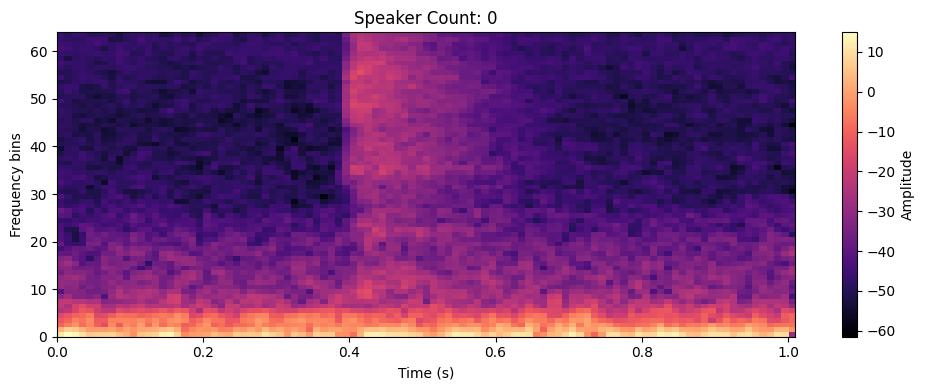

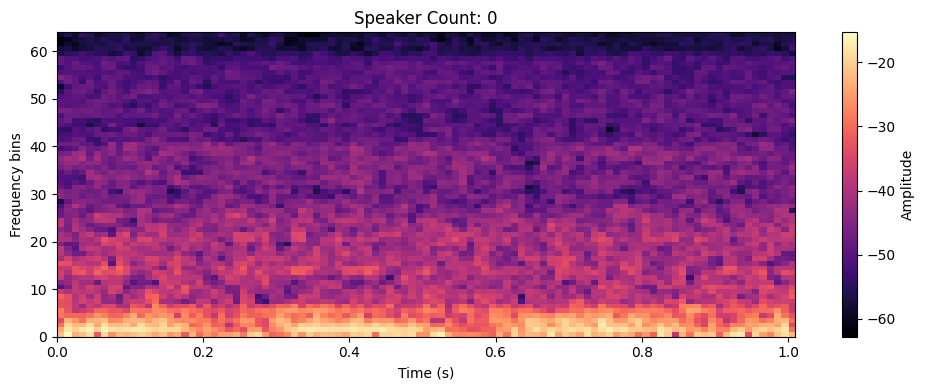

In [9]:
plot_spectrogram_with_audio(audio_dir='clips_rir', spec_dir='specs_rir', clip = 'largeroom1_9_clip1', df = df_noise)
plot_spectrogram_with_audio(audio_dir='clips_rir', spec_dir='specs_rir', clip = 'smallroom2_9_clip1', df = df_noise)

In [14]:
zero_class_2 = len(df_noise) + _class_counts[0] #_class_counts is defined in part 1. It's the observation count in the inital dataset
print(f" Total 0-speaker samples: {len(df_noise)} + {_class_counts[0]} = {zero_class_2} ")

 Total 0-speaker samples: 2700 + 1527 = 4227 


#### This is good but some more would be even better.
~2 hours of noise data (any recording without speech and other significant sounds) was recorded manually by the author and added to the zero-class

In [15]:
# a simpler version of the wrapper used in part 1. 
# No searching through nested directory, just pulls wavs from in_dir
def wavs_to_clips(in_dir, out_dir):
    in_dir = Path(in_dir)
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # Iterate over all .wav files in the input directory
    for raw_path in sorted(in_dir.glob("*.wav")):
        base_name = raw_path.stem  # filename without extension

        # Split into 1s clips
        clips = split_wav_into_clips(raw_path, clip_dur=1.0, sr=16000)

        # Save clips (excluding first and last)
        for idx, clip in enumerate(clips[1:-1], start=1):
            fname = f"{base_name}_clip{idx}.wav"
            sf.write(out_dir / fname, clip, 16000)

In [18]:
raw_dir = r'data/author_data/raw'
clips_dir= r'data/author_data/clips_real'
specs_dir = r'data/author_data/specs_real'


#wavs_to_clips(in_dir=raw_dir, out_dir=clips_dir)
#clips_to_specs(clips_dir, specs_dir)


# List all spectrogram files
specs_dir = Path(specs_dir)
spec_files = sorted(specs_dir.glob("*.pt"))


# Create DF of labelled spectrogram files
records = [
    {
        "spec_dir": str(path),
        "clip_dir": str(Path(clips_dir) / (path.stem + ".wav")),
        "speaker_count": 0,
        "speakers": []
    }
    for path in spec_files
]
df_noise2 = pd.DataFrame(records)


# Save to CSV
df_noise2.to_csv("data/labels/realnoise.csv", index=False)
df_noise2.head()

,spec_dir,clip_dir,speaker_count,speakers
0,data\author_data\specs_real\Recording_downstai...,data\author_data\clips_real\Recording_downstai...,0,[]
1,data\author_data\specs_real\Recording_downstai...,data\author_data\clips_real\Recording_downstai...,0,[]
2,data\author_data\specs_real\Recording_downstai...,data\author_data\clips_real\Recording_downstai...,0,[]
3,data\author_data\specs_real\Recording_downstai...,data\author_data\clips_real\Recording_downstai...,0,[]
4,data\author_data\specs_real\Recording_downstai...,data\author_data\clips_real\Recording_downstai...,0,[]


In [19]:
final_zero_class = zero_class_2 + len(df_noise2)
print(f"Final count of zero class: {final_zero_class}")

Final count of zero class: 11719


This should be enough. Usually a 1:1 class balance is preferable, but that rule assumes that the classes are equally hard to learn. No-speaker samples are much easier to predict (no discernible pattern = no speaker), therefore not as many 0 speaker samples are needed as the other classes.

Let's combine these observations with libricss and check the total dataset balance:

In [20]:
df_comb = pd.concat([df, df_noise, df_noise2], axis=0, ignore_index=True)

_class_counts = [len(df_comb[df_comb['speaker_count'] == i]) for i in range(3)]
for i in range(len(_class_counts)):
    print(f"Clips with {i} speakers: {_class_counts[i]}")
print(f"Total clips: {len(df_comb)}")

df_comb.to_csv('data/labels/libricss_and_noise.csv')

Clips with 0 speakers: 11719
Clips with 1 speakers: 29309
Clips with 2 speakers: 5251
Total clips: 46279


Great. Now it's clear that we need to create more n=2 clips and n=3 clips, as well as a 'ceiling' class, 4+. Having ~25,000 samples of each will give a good balance.

## Generating overlayed clips from LibriCSS clips
*Intuition*: by using the mappings within `libricss_and_noise.csv` its possible to overlay clips and sum their respective speaker counts. For example, overlaying two clips with 1 and 2 speakers respectively will result in a new clip with 3 speakers.

*Why?*: This will provide representations of more speakers than there are available in the data set. Additionally this is an opportunity to  improve class imbalance by intentionally creating more clips of under-represented classes.

*How?*:
The following data will be created:
- Pairs of 1-speaker clips will be combined to create 2-speaker clips
- 2-speaker clips will be combined with 0-speaker clips to create noisy 2-speaker clips (higher variance = better generalisation)
- Similarly 1-speaker clips will be combined with 0-speaker clips

Then, when the initial augmentation is complete, a second augmentation will take place, which includes the original clips and the new clips:
- 2-speaker clips will be combined with 1-speaker clips to give 3-speaker clips.

A final augmentation will combine all combinations of clips to create the 4+ class, which is a class for any speakers >4. Having 4+ speakers speaking at once is rare and usually means a chaotic environment, so an accurate class prediction isn't necessary beyond 3 speakers.

**This will result in a balanced 5 class dataset.** 

In [24]:
# Bring in the labels
try: labels = df_comb.copy()
except: 
    labels = pd.read_csv(r'data/labels/libricss_and_noise.csv')

# Convert 'speakers' to a list of strings, not a single string or list of ints
def to_list(val):
    if isinstance(val, str):
        return ast.literal_eval(val)
    elif isinstance(val, int):
        return [val]
    return val
labels['speakers'] = labels['speakers'].apply(to_list)

df_main = labels.copy(); df_main

,spec_dir,clip_dir,speaker_count,speakers
0,data\specs_libricss\0L_session0_clip1.pt,data\clips_libricss\0L_session0_clip1.wav,0,[]
1,data\specs_libricss\0L_session0_clip10.pt,data\clips_libricss\0L_session0_clip10.wav,1,[8224]
2,data\specs_libricss\0L_session0_clip100.pt,data\clips_libricss\0L_session0_clip100.wav,1,[3575]
3,data\specs_libricss\0L_session0_clip101.pt,data\clips_libricss\0L_session0_clip101.wav,1,[3575]
4,data\specs_libricss\0L_session0_clip102.pt,data\clips_libricss\0L_session0_clip102.wav,1,[3575]
...,...,...,...,...
46274,data\author_data\specs_real\Recording_upstairs...,data\author_data\clips_real\Recording_upstairs...,0,[]
46275,data\author_data\specs_real\Recording_upstairs...,data\author_data\clips_real\Recording_upstairs...,0,[]
46276,data\author_data\specs_real\Recording_upstairs...,data\author_data\clips_real\Recording_upstairs...,0,[]
46277,data\author_data\specs_real\Recording_upstairs...,data\author_data\clips_real\Recording_upstairs...,0,[]


In [22]:
# The overlay function. Samples will be taken randomly with replacement from df1 and df2 and combined. 
# If the two samples have the same speaker the attempt fails
# This repeats until there are num_samples samples
def data_overlay(df1, df2, num_samples, clip_output=r'data/clips_aug', sr=16000, verbose=True, export_name=None, max_attempts=200000, tidy=True):
    """
    Args:
        df1 (pd.DataFrame): First dataframe to sample base clips from.
        df2 (pd.DataFrame): Second dataframe to sample overlay clips from. Can be the same as df1.
        num_samples (int): Number of overlay samples to generate.
        output_folder (str): Path to save generated .wav files.
        sr (int): Target audio sample rate in Hz.
        verbose (bool): Whether to print progress updates.
        export_name (str): Whether to save generated audio and labels to disk.
        max_attempts (int): Maximum number of overlay attempts before giving up (default 200,000).
    """

    # prevents accidental re-runs & data bloat. tidy == True by default
    if tidy:
        assert not any(Path(clip_output).glob("*.wav")), f"{clip_output} must be empty before running."

    # init
    start = time()
    extended_labels = []
    seen_pairs = set()
    attempts = 0
    eq = df1.equals(df2)

    folder_path = Path("data/clips_aug") 
    file_count = sum(1 for f in folder_path.iterdir() if f.is_file())

    # Main loop
    while len(extended_labels) < num_samples and attempts < max_attempts:

        # if enabled, give progress updates
        if verbose and attempts % 1000 == 0:
            elapsed = time() - start
            print(f'Attempt {attempts} | Samples created: {len(extended_labels)} / {num_samples} | Elapsed: {elapsed:.1f}s')

        attempts += 1

        # Randomly select two rows - one from each df.
        # overlay_row has to drop base_row if they are from the same df to prevent the same sample being taken
        base_row = df1.sample(n=1).iloc[0]
        overlay_row = df2.drop(base_row.name).sample(n=1).iloc[0] if eq else df2.sample(n=1).iloc[0]

        # Avoid overlaying the same speaker twice (unrealistic that one person can say two things at once!)
        if set(base_row['speakers']) & set(overlay_row['speakers']):
            continue

        # set mapping
        base_clip = base_row['clip_dir']
        base_count = base_row['speaker_count']
        base_speakers = base_row['speakers']

        overlay_clip = overlay_row['clip_dir']
        overlay_count = overlay_row['speaker_count']
        overlay_speakers = overlay_row['speakers']

        # Avoid overlaying the same clips twice
        pair_key = tuple(sorted((base_clip, overlay_clip)))     # (we use `sorted` so that [A,B] == [B,A])
        if pair_key in seen_pairs:
            continue
        seen_pairs.add(pair_key)

        # Load and align audio from mapping
        base_audio, _ = librosa.load(base_clip, sr=sr)
        overlay_audio, _ = librosa.load(overlay_clip, sr=sr)

        # Pad output to the longer audio length
        max_len = max(len(base_audio), len(overlay_audio))
        base_audio = np.pad(base_audio, (0, max_len - len(base_audio)))
        overlay_audio = np.pad(overlay_audio, (0, max_len - len(overlay_audio)))

        # Overlay by summing
        mixed_audio = base_audio + overlay_audio
        mixed_audio = mixed_audio / np.max(np.abs(mixed_audio))  # Normalize

        # Save new clip, if enabled
        clip_id = str(folder_path / f"overlay_{file_count + len(extended_labels) + 1}.wav")
        if export_name is not None:
            sf.write(clip_id, mixed_audio, sr)

        # Log new label
        extended_labels.append([clip_id, base_clip, overlay_clip, base_count + overlay_count, base_speakers + overlay_speakers])


    # Convert new labels to DataFrame
    df = pd.DataFrame(extended_labels, columns=['clip_dir', 'clip_1', 'clip_2', 'speaker_count', 'speakers'])

    # save labels, if enabled
    if export_name is not None:
        df.to_csv(f'data/labels/overlay_{export_name}.csv', index=False)
    
    print(f"data_overlay() complete. Created {len(extended_labels)} new clips in {attempts} attempts.")
    if len(extended_labels) < num_samples:
        print(f"Warning: Only {len(extended_labels)} samples were created (target was {num_samples}). Consider increasing max_attempts or have more distinct speakers.")
    
    return df

### Running the wrapper defined above
The cell below is **very** expensive; 140,000 files are added to local disk.

In [25]:
# Helper - splits a df by speaker_count
def split_by_speaker_count(df, count_col='speaker_count'):
    return {f'df_{count}': group.reset_index(drop=True)
            for count, group in df.groupby(count_col)}

# Main
def augment(df): 

    dfs_dict = split_by_speaker_count(df)
    # Access individual DataFrames
    df_0 = dfs_dict.get('df_0')  # Clips with 0 speakers
    df_1 = dfs_dict.get('df_1')  # Clips with 1 speaker
    df_2 = dfs_dict.get('df_2')  # Clips with 2 speakers



    #df_A_B --> samples with A speakers are overlayed onto samples with B speakers. 
    # e.g. df_1_2: 1-speaker + 2-speaker = 3-speaker



    # 2 speaker 
    # 5,000 existing + 20,000 new = 25,000 total samples
    df_1_1 = data_overlay(df1 = df_1, df2= df_1, num_samples=17500, tidy=True, export_name='1_1')
    df_0_2 = data_overlay(df1 = df_0, df2= df_2, num_samples=2500, tidy=False, export_name='0_2')

    # add 2 speaker to main and re-seperate
    df_main = pd.concat([df_main, df_1_1, df_0_2], axis=0, ignore_index=True)

    df_dict = split_by_speaker_count(df_main)
    df_2 = df_dict.get('df_2')  # Re-init df_2 with new 2-speaker clips



    # 3 speaker
    # 25,000 new samples
    df_2_1 = data_overlay(df1=df_2, df2=df_1, num_samples=25000, tidy=False, export_name='2_1')

    # add 3 speaker to main and re-seperate
    df_main = pd.concat([df_main, df_2_1], axis=0, ignore_index=True)

    df_dict = split_by_speaker_count(df_main)
    df_3 = df_dict.get('df_3')  # init df_3 now that 3-speaker clips exist



    # 4+ speaker
    # 25,000 new samples
    df_2_2 = data_overlay(df1=df_2, df2=df_2, num_samples=10000, tidy=False, export_name='2_2')
    df_3_1 = data_overlay(df1=df_3, df2=df_1, num_samples=7500, tidy=False, export_name='3_1')
    df_3_2 = data_overlay(df1=df_3, df2=df_2, num_samples=7500, tidy=False, export_name='3_2') # this gives some 5 speaker samples too (fine for 4+ class)

    # add 4+ speaker to main - This is the final augmentation
    df_main = pd.concat([df_main, df_2_2, df_3_1, df_3_2], axis=0, ignore_index=True)
    df_main.tail(10)


    # Save and return
    df_main.drop(columns=['clip_1', 'clip_2'], inplace=True)
    df_main.to_csv(r'data/labels/final_labels.csv')
    return df_main



# Creates synthetic sound clips and spectrograms. Returns the final dataset as a df and saves to csv
# --> Uncomment with caution!! <--

# df_main = augment(labels)
# print("Clips added to data/clips_aug \n Now creating spectrograms in data/specs_aug")
# clips_to_specs(clips_dir = r'data/clips_aug', specs_dir= r'data/specs_aug')
# print("\n Spectrograms created in data/specs_aug \n --> Data augmentation complete <--")

### Viewing Results

In [26]:
folder_path = Path("data/clips_aug") 
file_count = sum(1 for f in folder_path.iterdir() if f.is_file())
print(f"Number of clips: {file_count}")

folder_path = Path("data/specs_aug")
file_count = sum(1 for f in folder_path.iterdir() if f.is_file())
print(f"Number of spectrograms: {file_count}")

print(f"Total Samples: {file_count + len(labels)}")

Number of clips: 70000
Number of spectrograms: 70000
Total Samples: 116279


#### Merging 4 and 5 speaker clips to one '4+' class

In [27]:
df_main['speaker_count'] = df_main['speaker_count'].apply(lambda x: '4+' if x in [4, 5] else x)
df_main['speaker_count'] = df_main['speaker_count'].astype(str)

#### Assigning labels to new spectrograms

In [28]:
# This finds nulls in and replaces them with the appropriate path derived from clip_dir
# e.g. clips_aug\overlay_1.wav  -->  specs_aug\overlay_1.pt
df_main.loc[df_main['spec_dir'].isnull(), 'spec_dir'] = (
    df_main.loc[df_main['spec_dir'].isnull(), 'clip_dir']
    .astype(str)
    .apply(lambda path: path.replace('data\\clips_aug', 'data\\specs_aug').replace('.wav', '.pt'))
)

#### Final Step: Assigning integer classes based on speaker count

In [137]:
mapping = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4+': 4
}

# Apply mapping
df_main['class'] = df_main['speaker_count'].map(mapping)

#### Last check

In [138]:
df_main

,spec_dir,clip_dir,speaker_count,speakers,class
0,data\specs_libricss\0L_session0_clip1.pt,data\clips_libricss\0L_session0_clip1.wav,0,[],0
1,data\specs_libricss\0L_session0_clip10.pt,data\clips_libricss\0L_session0_clip10.wav,1,[8224],1
2,data\specs_libricss\0L_session0_clip100.pt,data\clips_libricss\0L_session0_clip100.wav,1,[3575],1
3,data\specs_libricss\0L_session0_clip101.pt,data\clips_libricss\0L_session0_clip101.wav,1,[3575],1
4,data\specs_libricss\0L_session0_clip102.pt,data\clips_libricss\0L_session0_clip102.wav,1,[3575],1
...,...,...,...,...,...
116274,data\specs_aug\overlay_69996.pt,data\clips_aug\overlay_69996.wav,4+,"[3575, 1188, 6829, 8224, 7729]",4
116275,data\specs_aug\overlay_69997.pt,data\clips_aug\overlay_69997.wav,4+,"[7729, 7176, 1089, 237, 3570]",4
116276,data\specs_aug\overlay_69998.pt,data\clips_aug\overlay_69998.wav,4+,"[1089, 5142, 1320, 7021, 8455]",4
116277,data\specs_aug\overlay_69999.pt,data\clips_aug\overlay_69999.wav,4+,"[1320, 3575, 7729, 121, 4446]",4


In [139]:
# Define the expected categories in order
categories = ['0', '1', '2', '3', '4+']

# Count clips per category
_class_counts = [len(df_main[df_main['speaker_count'] == cat]) for cat in categories]

# Print results
for cat, count in zip(categories, _class_counts):
    print(f"Clips with {cat} speakers: {count}")
print(f"Total clips: {len(df_main)}")

Clips with 0 speakers: 11719
Clips with 1 speakers: 29309
Clips with 2 speakers: 25251
Clips with 3 speakers: 25000
Clips with 4+ speakers: 25000
Total clips: 116279


### All done! The dataset is ready for an ML model :)

In [140]:
df_main.to_csv(r'data\labels\final_labels.csv', index=False)